# first just make two models that works on mnist. One fully connected an then one conv

In [107]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import math
import time

#tds
import torchvision

#git
#from __future__ import print_function
#import argparse
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

In [108]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.1
momentum = 0.5
log_interval = 10
dataset = 'mnist'

#nj stuff i dont get
#random_seed = 1
#torch.backends.cudnn.enabled = False
#torch.manual_seed(random_seed)

In [109]:
# Would prefer MNIST but Yann LeCun has serverissues
# normalization incorrect for kmnist
if dataset == 'mnist':
    train_loader = torch.utils.data.DataLoader(
      torchvision.datasets.MNIST('data/', train=True, 
                                  download=True,
                                  transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                     (0.1307,), (0.3081,))
                                 ])),
                                  batch_size=batch_size_train, 
                                    shuffle=True)

    test_loader = torch.utils.data.DataLoader(
      torchvision.datasets.MNIST('data/', train=False, download=True,
                                 transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                     (0.1307,), (0.3081,))
                                 ])),
      batch_size=batch_size_test, shuffle=True)
    print('loaded the mnist data')
elif dataset == 'digits':
    from sklearn.datasets import load_digits
    digits = load_digits(n_class=5, return_X_y=False)

    my_train = dict()
    my_test = dict()
    length = len(digits['data'])
    for i in range(length):
        if i < int(0.75 * length):
            my_train[i] = (torch.tensor([digits.images[i]]).double() / 16, torch.tensor(digits.target[i]))
        else:
            j = i - int(0.75 * length)
            if j < 0:
                print('I fucked up')
            my_test[j] = (torch.tensor([digits.images[i]]) / 16, torch.tensor(digits.target[i]))

    if j not in my_test:
        print('I fucked up 2')

    train_loader = torch.utils.data.DataLoader(my_train, batch_size=64, shuffle=True,)
    test_loader = torch.utils.data.DataLoader(my_test, batch_size=1, shuffle=True)
    print('loaded the digits data')
  

loaded the mnist data


In [110]:
a = torch.double(4)

a

TypeError: 'torch.dtype' object is not callable

In [111]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([64, 1, 28, 28])

In [112]:
example_data[0]

tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0

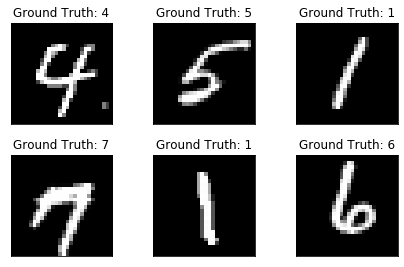

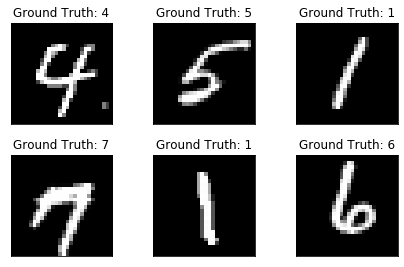

In [113]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [114]:
# counts trainable weights in a model
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [115]:
# not feasible for digits
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride = 1)
        self.conv2 = nn.Conv2d(6, 6, kernel_size=5, stride = 1)
        self.conv2_drop = nn.Dropout2d()
        self.flatten_nbr = 4*4*6
        self.fc1 = nn.Linear(self.flatten_nbr, 50)  # 4*4*20
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, self.flatten_nbr)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim = 1)

print(Net())
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_params(Net())

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=96, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


6422

In [116]:
class MLP(nn.Module):

    def __init__(self):
        super(MLP, self).__init__()
        inputsize = int(example_data.shape[-1] / 1) ** 2
        self.l1 = nn.Linear(inputsize, 64)
        self.l4 = nn.Linear(64, 10)

    def forward(self, x):
        #x = F.avg_pool2d(x, 2)
        x = x.view(x.shape[0],-1)
        x = F.relu(self.l1(x))
        x = self.l4(x)
        return F.log_softmax(x, dim = 1)

print(MLP())
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_params(MLP())

MLP(
  (l1): Linear(in_features=784, out_features=64, bias=True)
  (l4): Linear(in_features=64, out_features=10, bias=True)
)


50890

In [117]:
# not feasible for digits
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride = 1)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3, stride = 1)
        self.conv2_drop = nn.Dropout2d()
        self.flatten_nbr = 4*4*20
        self.fc1 = nn.Linear(self.flatten_nbr, 256)  # 4*4*20
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, self.flatten_nbr)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim = 1)

print(CNN())
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_params(CNN())

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


86826

In [118]:
outputs.size()

torch.Size([1000, 10])

In [128]:
criterion = nn.CrossEntropyLoss()       # what is this

network = MLP()

dataiter = iter(train_loader)
images, labels = dataiter.next()
outputs = network(images)

# what is default values for lr and momentum
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [124]:
# tog typ en kvart
t0 = time.perf_counter()
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = network(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training it took ', (time.perf_counter() - t0)/60, ' minutes to train')

[1,   200] loss: 0.443
[1,   400] loss: 0.221
[1,   600] loss: 0.189
[1,   800] loss: 0.154
Finished Training it took  0.22155005498304187  minutes to train


In [125]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
outputs = network(images)


_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % predicted[j]
                              for j in range(4)))

Predicted:  tensor(7) tensor(6) tensor(7) tensor(5)


In [126]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = network(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
   
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 95 %


In [ ]:
med net lr = 0.01
[1,   200] loss: 2.228
[1,   400] loss: 1.623
[1,   600] loss: 1.265
[1,   800] loss: 1.060
Finished Training it took  9.284094596350041  minutes to train
accuracy of the network on the 10000 test images: 71 %
82 % med lr = 0.1

In [52]:
555/60

9.25